## MACHINE LEARNING PROJECT

In [1]:
artists = ['Pablo Picasso', 'Caravaggio', 'Diego Rivera', 'Frida Kahlo', 'Gustav Klimt',
'Jackson Pollock', 'Claude Monet', 'Piet Mondrian', 'Andy Warhol',
'Roy Lichtenstein', 'Diego Velazquez', 'Wassily Kandinsky',
'Katsushika Hokusai', 'Edgar Degas', 'Joaquín Sorolla']

artists.sort()

This is a silly cell to check if github repository is correctly added

I'll try to build and train a ML model to predict if a painting is an original paiting from a known artist  
based on the colors used in the painting.

I decided to start form a list of 15 artis with a noticeable style difference:
* Andy Warhol
* Caravaggio
* Claude Monet
* Diego Rivera
* Diego Velazquez
* Edgar Degas
* Frida Kahlo
* Gustav Klimt
* Jackson Pollock
* Joaquín Sorolla
* Katsushika Hokusai
* Pablo Picasso
* Piet Mondrian
* Roy Lichtenstein
* Wassily Kandinsky

___


Previous work:
* Get paintings by artist
* Classify the paintings by type using KNN or clustering method

* For one group of paintings create a DF with:
    * 25 colors
    * Hollow portion
* paintings of Caravaggio (1) an not (0)
* Use SVM to


Extra:
* Try with B&W images

___

### PREREQUISITES

To process images I'll be using OpenCV library. It is important to take a look at the [docs][OpenCV installation and usage] before running the next cell.
For this project I'll use the 'main modules package'

[OpenCV installation and usage]:https://pypi.org/project/opencv-python/

In [ ]:
# !pip install opencv-python

### IMPORTS

In [30]:
# Modules used for EDA
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


# Modules used for image processing
import cv2


# Modules used for ML
from sklearn.cluster import KMeans

In [35]:
# Utils
from utils import get_image_rgb, get_image_gre, rgb2hex, get_colors

ImportError: cannot import name 'get_image_rgb' from 'utils' (/Volumes/GoogleDrive/My Drive/BatallaPro/01.- Programación/Code/The Bridge/Data_science_bootcamp/Entregables/ML/utils.py)

In [26]:
# Modules settings
%matplotlib inline

### GETTING IMAGES

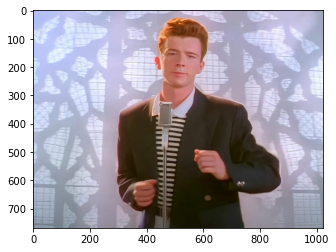

In [14]:
sample_img = cv2.imread('./images/sample.jpeg')

 # By default, OpenCV reads image in the sequence Blue Green Red (BGR).
 # Thus, to view the actual image we need to convert the rendering to Red Green Blue (RGB).
sample_img = cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB)
 
plt.imshow(sample_img);

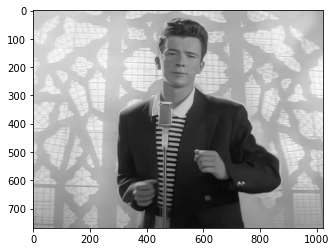

In [15]:
# To use a greyscale version of the image
sample_img_grey = cv2.cvtColor(sample_img, cv2.COLOR_BGR2GRAY)
plt.imshow(sample_img_grey, cmap='gray');

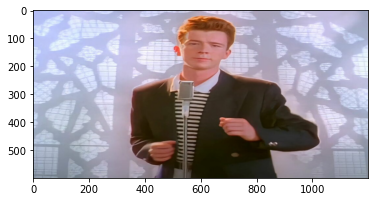

In [16]:
# To resize images
sample_img_res = cv2.resize(sample_img, (1200, 600))
plt.imshow(sample_img_res);